In [34]:
# Article:  https://medium.com/@vinayarun/from-scratch-an-lstm-model-to-predict-commodity-prices-179e12445c5a
# load required libraries
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

num_features = 53 #Number of features in the dataset
lag_steps = 1 #Number of lagged time features to be generated
label_feature = 'POILBRE' #The column in dataset that model is being built to predict

In [35]:
# This function arranges the dataset to be used for surpervised learning by shifting the input values of features by the number
# time steps given in lag_steps

def sequential_to_supervised(data, lag_steps = 1, n_out = 1, dropnan = True):
    features = 1 if type(data) is list else data.shape[1] # Get the number of features in dataset
    df = DataFrame(data)
    cols = list()
    feature_names = list()
    
    for i in range(lag_steps, 0, -1):
        cols.append(df.shift(i)) # This will be the shifted dataset
        feature_names += [(str(df.columns[j])) + '(t-%d)' % (i) for j in range(features)] # Names of the shifted features
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            feature_names += [(str(df.columns[j])) + '(t)'  for j in range(features)] # Names of the shifted features
        else:
            feature_names += [(str(df.columns[j])) + '(t+%d)' % (i) for j in range(features)] # Names of the shifted features
    
    agg = concat(cols, axis=1) 
    agg.columns = feature_names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
# Reading in the dataset which is in .csv format, has column headings and has an index column

#dataset = read_csv("Dataset.csv", header = 0, index_col = 0, squeeze = True, usecols = (i for i in range(0, num_features+1)))
#supervised_dataset = sequential_to_supervised(dataset, lag_steps)


#Use this to read or try the instruction above.  I could not get the instruction above to work.
dataset = read_csv('Dataset.csv', header = 0, index_col = 0, squeeze = True, usecols = [i for i in range(0, num_features+1)])
supervised_dataset = sequential_to_supervised(dataset, lag_steps)







# Move label column to the end of dataset
cols_at_end = [label_feature + '(t)']
supervised_dataset = supervised_dataset[[c for c in supervised_dataset if c not in cols_at_end] + [c for c in cols_at_end if c in supervised_dataset]]

#print(supervised_dataset.shape)  # Used for debugging

In [37]:
# Dropping the current timestep columns of features other than the one being predicted, which will be the label or y 
supervised_dataset.drop(supervised_dataset.columns[(num_features*lag_steps) : (num_features*lag_steps + num_features -1)], axis=1, inplace=True)
#print(supervised_dataset.shape) # Used for debugging
scaler = MinMaxScaler(feature_range=(0, 1))
supervised_dataset_scaled = scaler.fit_transform(supervised_dataset) # Scaling all values

In [38]:
split = int(supervised_dataset_scaled.shape[0]*0.8) # Splitting for traning and testing
train = supervised_dataset_scaled[:split, :]
test = supervised_dataset_scaled[split:, :]

train_X, train_y = train[:, :-1], train[:, -1] # The label column is separated out
test_X, test_y = test[:, :-1], test[:, -1]
#print(train_X.shape) # Used for debugging
#print(test_X.shape) # Used for debugging
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) # Reshaping done for LSTM as it need 3D input
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(train_X.shape) # Used for debugging
#print(test_X.shape) # Used for debugging

Train on 234 samples, validate on 59 samples
Epoch 1/70
 - 1s - loss: 0.2538 - val_loss: 0.3857
Epoch 2/70
 - 0s - loss: 0.1764 - val_loss: 0.2519
Epoch 3/70
 - 0s - loss: 0.1328 - val_loss: 0.1545
Epoch 4/70
 - 0s - loss: 0.1071 - val_loss: 0.1349
Epoch 5/70
 - 0s - loss: 0.1034 - val_loss: 0.1314
Epoch 6/70
 - 0s - loss: 0.1309 - val_loss: 0.1456
Epoch 7/70
 - 0s - loss: 0.1437 - val_loss: 0.1404
Epoch 8/70
 - 0s - loss: 0.1318 - val_loss: 0.1252
Epoch 9/70
 - 0s - loss: 0.1094 - val_loss: 0.1222
Epoch 10/70
 - 0s - loss: 0.0920 - val_loss: 0.1226
Epoch 11/70
 - 0s - loss: 0.0849 - val_loss: 0.1222
Epoch 12/70
 - 0s - loss: 0.0789 - val_loss: 0.1188
Epoch 13/70
 - 0s - loss: 0.0713 - val_loss: 0.1129
Epoch 14/70
 - 0s - loss: 0.0642 - val_loss: 0.1076
Epoch 15/70
 - 0s - loss: 0.0634 - val_loss: 0.1039
Epoch 16/70
 - 0s - loss: 0.0631 - val_loss: 0.1017
Epoch 17/70
 - 0s - loss: 0.0607 - val_loss: 0.0984
Epoch 18/70
 - 0s - loss: 0.0561 - val_loss: 0.0957
Epoch 19/70
 - 0s - loss: 0.

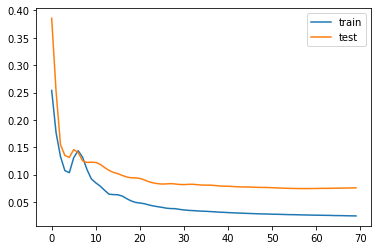

In [39]:
# Defining the LSTM model to be fit
model = Sequential()
model.add(LSTM(85, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fitting the model
history = model.fit(train_X, train_y, epochs=70, batch_size=175, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# Plotting the training progression
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
# Using the trained model to predict the label values in test dataset
yhat = model.predict(test_X)

#print(yhat.shape) # Used for debugging
#print(test_X.shape) # Used for debugging

# Reshaping back into 2D for inversing the scaling
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) 
#print(test_X.shape) # Used for debugging

In [41]:
# Concatenating the predict label column with Test data input features, needed for inversing the scaling
inv_yhat = concatenate((test_X[:, 0:], yhat), axis=1) 
inv_yhat = scaler.inverse_transform(inv_yhat) # Rescaling back
#print(inv_yhat.shape) # Used for debugging
inv_yhat = inv_yhat[:, num_features*lag_steps] # Extracting the rescaled predicted label column

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 0:], test_y), axis=1) # Re joing the test dataset for inversing the scaling
inv_y = scaler.inverse_transform(inv_y) # Rescaling the actual label column values
inv_y = inv_y[:, num_features*lag_steps] # Extracting the rescaled actual label column

rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat)) # Calculating RMSE
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.794


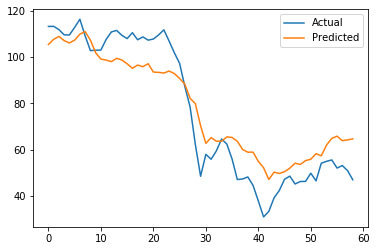

In [42]:
pyplot.plot(inv_y, label = 'Actual')
pyplot.plot(inv_yhat, label = 'Predicted')
pyplot.legend()
pyplot.show()

In [43]:
print (inv_yhat) 

[105.54865965 107.73483161 109.01727546 107.2167058  106.17718474
 107.39960245 110.00262136 111.10870005 107.44206826 101.93875496
  99.17930564  98.76439669  98.09951566  99.52896622  98.78164634
  97.18322016  95.19743861  96.60208725  95.89488095  97.18732546
  93.56970577  93.4399709   93.13765811  94.00563682  92.92627586
  90.80594403  88.2942403   82.20037779  79.86909274  70.30084111
  62.67893427  65.15582062  63.61683622  63.57472546  65.47922948
  65.2350714   63.56060471  60.03326463  58.84436983  58.86639421
  54.85684784  52.14342965  47.00928636  50.20489973  49.64414168
  50.39633245  51.93437744  54.08901625  53.52025472  55.20334253
  55.79917686  58.19647587  57.28154511  61.93881901  64.84085167
  65.79763061  63.83577814  64.16638792  64.61389147]


In [44]:
print (inv_y)

[113.34 113.38 111.97 109.71 109.64 112.93 116.46 109.24 102.88 103.03
 103.11 107.72 110.96 111.62 109.48 108.08 110.63 107.57 108.81 107.41
 107.88 109.68 111.87 106.98 101.92  97.34  87.27  78.44  62.16  48.42
  57.93  55.79  59.39  64.56  62.35  55.87  46.99  47.23  48.12  44.42
  37.72  30.8   33.2   39.07  42.25  47.13  48.48  45.07  46.14  46.19
  49.73  46.44  54.07  54.89  55.49  51.97  53.06  50.87  46.89]
